In [1]:
import numpy as np
import pickle
import os
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
import sklearn

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=64
CHANNELS=3
EPOCHS=20 

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "VegetableImages",    #directory
    shuffle=True,      #randomly shuffle the images
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 15000 files belonging to 15 classes.


In [4]:
class_names=dataset.class_names
class_names

['Bean',
 'Bitter_Gourd',
 'Bottle_Gourd',
 'Brinjal',
 'Broccoli',
 'Cabbage',
 'Capsicum',
 'Carrot',
 'Cauliflower',
 'Cucumber',
 'Papaya',
 'Potato',
 'Pumpkin',
 'Radish',
 'Tomato']

In [5]:
len(dataset)

235

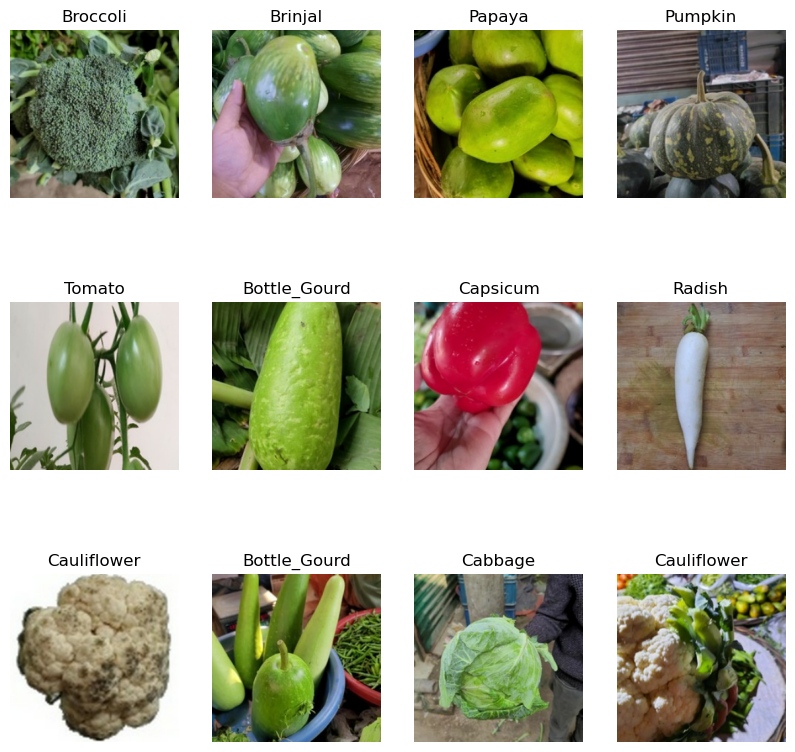

In [6]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))  
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [7]:
#train_size=0.8
#len(dataset)*train_size

In [8]:
#train_ds=dataset.take(1875)
#ilk 1875 batchı train datasete atadık
#len(train_ds)

In [9]:
#test_ds=dataset.skip(1875) #1875.batch dan sonrası
#len(test_ds)

In [10]:
#val_size=0.1
#len(dataset)*val_size

In [11]:
#val_ds=test_ds.take(234)
#len(val_ds)

In [12]:
#test_ds=test_ds.skip(234)
#len(test_ds)

In [13]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):

    ds_size=len(ds)

    if shuffle:
        ds=ds.shuffle(shuffle_size, seed=12)
    
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)

    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [14]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [15]:
len(train_ds)

188

In [16]:
len(val_ds)

23

In [17]:
len(test_ds)

24

In [18]:
train_ds=train_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)
#cache: image i diskten okur, bir daha çağırılma için memory de tutar
#prefetch: if cpu is busy training, prefetch will load the next set of batch from your disk (performansı gelistirir)
#optimize edildi, training fast olacak

In [19]:
resize_and_rescale= tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)  #stable
])

#bu resize ve rescale layer sonunda nihai(ultimate) modele gidecek prediction yaparken 256x256 resim gelmezse bu model will take care of resizing it

In [20]:
data_augmentation=tf.keras.Sequential([
     layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
     layers.experimental.preprocessing.RandomRotation(0.2)
])

#predicting yaparken rotated(döndürülmüş) veya farklı contrastta bir resim gelirse model performanı iyi olmaz, modeli robust(güçlü) yapmak için data augmentation
#(yeni training samples oluşturulmuş olur)

In [21]:
input_shape=(BATCH_SIZE, IMAGE_SIZE,IMAGE_SIZE, CHANNELS)
n_classes=15

model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (64, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (64, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (64, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (64, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (64, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (64, 62, 62, 64)          0         
 g2D)                                                 

In [23]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [24]:
history= model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/20


188/188 [==============================] - 594s 3s/step - loss: 2.1489 - accuracy: 0.2387 - val_loss: 1.5660 - val_accuracy: 0.4389
Epoch 2/20
188/188 [==============================] - 415s 2s/step - loss: 1.3876 - accuracy: 0.4959 - val_loss: 1.2237 - val_accuracy: 0.5489
Epoch 3/20
188/188 [==============================] - 388s 2s/step - loss: 1.1469 - accuracy: 0.5905 - val_loss: 0.9544 - val_accuracy: 0.6529
Epoch 4/20
188/188 [==============================] - 385s 2s/step - loss: 0.8997 - accuracy: 0.6810 - val_loss: 0.9210 - val_accuracy: 0.6984
Epoch 5/20
188/188 [==============================] - 400s 2s/step - loss: 0.7862 - accuracy: 0.7225 - val_loss: 0.9559 - val_accuracy: 0.6807
Epoch 6/20
188/188 [==============================] - 445s 2s/step - loss: 0.6418 - accuracy: 0.7738 - val_loss: 0.5640 - val_accuracy: 0.8139
Epoch 7/20
188/188 [==============================] - 424s 2s/step - loss: 0.5605 - accuracy: 0.8083 - val_loss: 0.6120 - val_accuracy: 0.79

In [25]:
scores=model.evaluate(test_ds)

24/24 [==============================] - 110s 1s/step - loss: 0.1552 - accuracy: 0.9577


In [26]:
scores

[0.15519694983959198, 0.9576823115348816]

In [1]:
history

history


In [28]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 188}

In [29]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [30]:
acc=history.history["accuracy"]
val_acc=history.history["val_accuracy"]

loss=history.history["loss"]
val_loss=history.history["val_loss"]

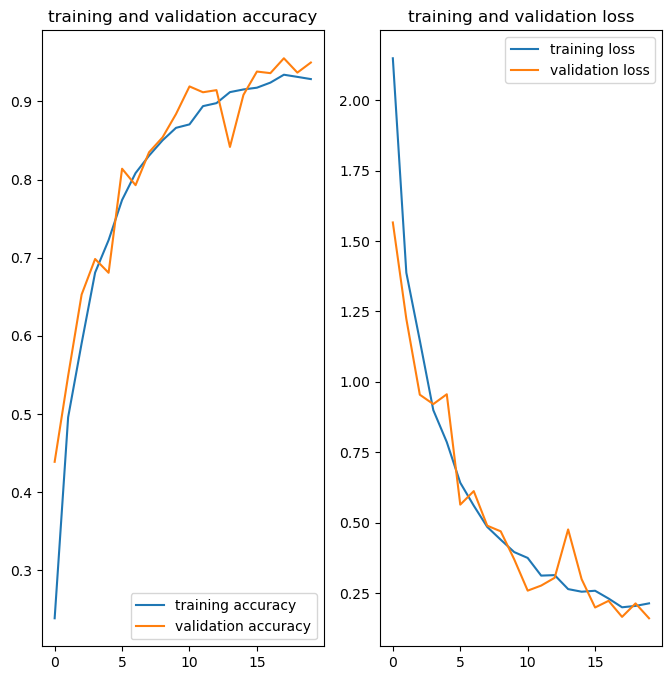

In [31]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc, label="training accuracy")
plt.plot(range(EPOCHS),val_acc, label="validation accuracy")
plt.legend(loc="lower right")
plt.title("training and validation accuracy")


plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss, label="training loss")
plt.plot(range(EPOCHS),val_loss, label="validation loss")
plt.legend(loc="upper right")
plt.title("training and validation loss")
plt.show()

first image to predict
first image's actual label: Carrot
2/2 [==============================] - 0s 187ms/step
predicted label: Carrot


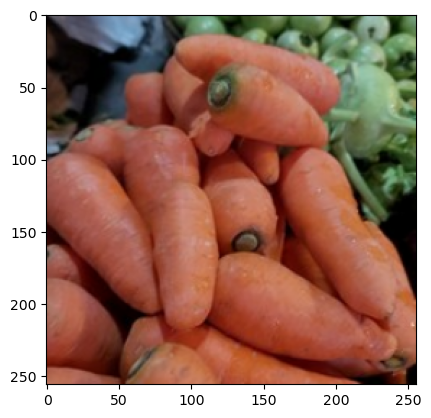

In [35]:
import numpy as np
for image_batch, label_batch in test_ds.take(1):

    #plt.imshow(image_batch[0].numpy().astype("uint8"))
    first_image=image_batch[0].numpy().astype("uint8")
    first_label=label_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("first image's actual label:", class_names[first_label])

    batch_prediction= model.predict(image_batch) #32 images için prediction
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

#activation olarak softmax kullandığın için return: olasılık
#hangi classa ait olduğunu olasılığı en yüksek olana bakarak anla

In [36]:
def predict(model, img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0) #create a batch

    predictions=model.predict(img_array)

    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 33ms/step


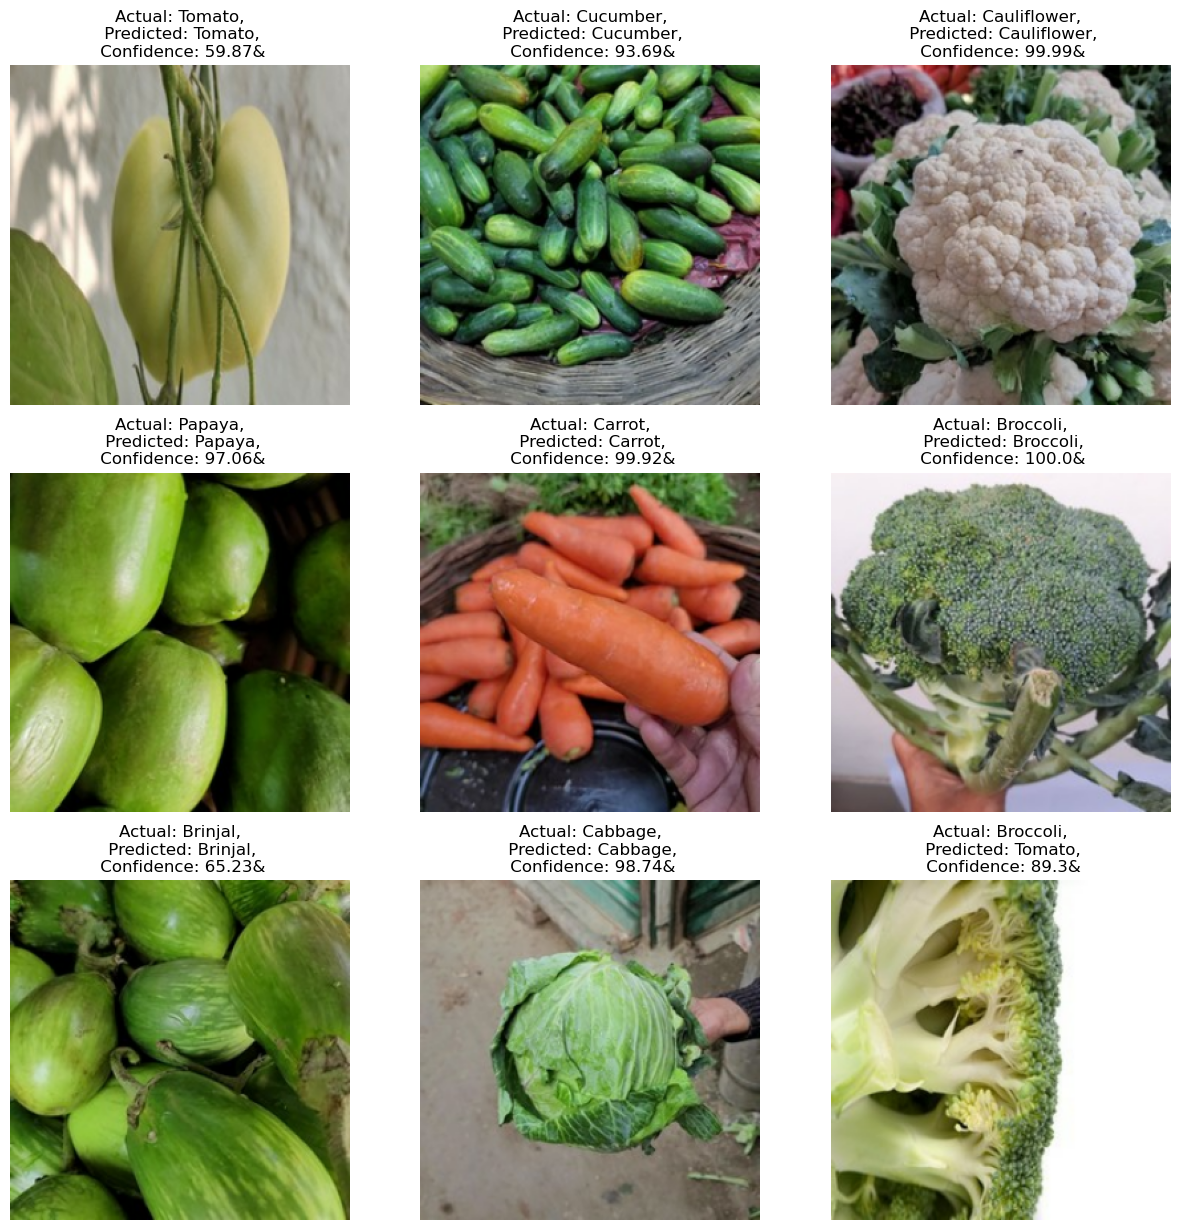

In [37]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range (9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence=predict(model, images[i].numpy())
        actual_class=class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence: {confidence}&")
        
        plt.axis("off")

In [40]:
import os
#os.listdir("../models")
model_version=max([int(i) for i in os.listdir("../models") + [0]]) + 1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/3\assets


INFO:tensorflow:Assets written to: ../models/3\assets
